# **Codenation**
## Desafio - Semana 8 

### __Importando módulos__

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [2]:
# Configs para o Seaborn
from IPython.core.pylabtools import figsize
sns.set()
figsize(12,8)

### __Carregando os dados__

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Gerando DataFrame de resposta
answer = pd.DataFrame()
answer['NU_INSCRICAO'] = df_test['NU_INSCRICAO']

### **Análise / Ajustes** 

In [4]:
features = df_test.columns.to_list()

In [5]:
features.append('NU_NOTA_MT')

In [6]:
train = df_train[features].copy()
test = df_test.copy()

In [7]:
# Deletando atributos de código que podem não acrescentar em nada ao nosso modelo
train.drop(['NU_INSCRICAO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT'], axis=1, inplace=True)
test.drop(['NU_INSCRICAO', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT'], axis=1, inplace=True)

In [8]:
train.select_dtypes('object').isnull().sum()

SG_UF_RESIDENCIA       0
TP_SEXO                0
Q001                   0
Q002                   0
Q006                   0
Q024                   0
Q025                   0
Q026                   0
Q027                7373
Q047                   0
dtype: int64

In [9]:
train['Q027'] = train['Q027'].fillna('-')
test['Q027'] = test['Q027'].fillna('-')

In [10]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [11]:
train.shape

(13730, 43)

In [12]:
test.shape

(4576, 42)

### **Selecionando e separando as colunas por tipo**

In [13]:
cat_columns = train.select_dtypes('object').columns
num_columns = train.select_dtypes({'int', 'float'}).columns
cat_columns

Index(['SG_UF_RESIDENCIA', 'TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047'],
      dtype='object')

In [14]:
num_columns = num_columns.drop('NU_NOTA_MT')
num_columns

Index(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO'],
      dtype='object')

### **Criando uma instância de** `make_column_transformer`
#### Para aplicar os preprocessadores em tipos distinstos de colunas (numeric, object)

In [15]:
column_trans = make_column_transformer((OneHotEncoder(), cat_columns),
                                       (MinMaxScaler(), num_columns),
                                        remainder='passthrough')

#### Gerando um Pipeline com o `make_column_tranformer` e `LinearRegression()`

In [16]:
lr_model = LinearRegression()
pipe = make_pipeline(column_trans, lr_model)

#### Selecionando X, Y

In [17]:
x = train.drop(['NU_NOTA_MT'], axis=1)
y = train['NU_NOTA_MT']
x_test = test.copy()

# ------ TESTES -------

### OneHotEncoder / MinMaxScaler / LinearRegression 

In [18]:
print(cross_val_score(pipe, x, y, cv=10, scoring='neg_root_mean_squared_error').mean())

-66.75831391538998


### OneHotEncoder / MinMaxScaler / RandomForestRegressor

In [23]:
rfr = RandomForestRegressor(n_jobs=-1)
rfr_pipe = make_pipeline(column_trans, rfr)

In [24]:
# Resultado
cross_val_score(rfr_pipe, x, y, cv=10, scoring='neg_root_mean_squared_error').mean()

-62.98483641151248

### OneHotEncoder / StandardScaler / RandomForestRegressor

In [25]:
column_trans_std_scaler = make_column_transformer(
                                                (OneHotEncoder(), cat_columns),
                                                (StandardScaler(), num_columns),
                                                 remainder="passthrough"
                                                 )

rf_reg = RandomForestRegressor(n_jobs=-1)
pipe_rf_reg = make_pipeline(column_trans_std_scaler, rf_reg)

In [26]:
# Resultado
cross_val_score(pipe_rf_reg, x, y, cv=10, scoring='neg_root_mean_squared_error').mean()

-63.07056951822326

### OneHotEncoder / StandardScaler / LinearRegression

In [27]:
lr_model = LinearRegression()
lr_pipe = make_pipeline(column_trans_std_scaler, lr_model)

In [28]:
cross_val_score(lr_pipe, x, y, cv=10, scoring='neg_root_mean_squared_error').mean()

-66.75268382313496

#### `A melhor combinação que mostrou o menor RMSE:`
##### **OneHotEncoder / MinMaxScaler / RandomForestRegressor**

## Testes exaustivos usando o `GridSearchCV()`
#### Usaremos o GridSearchCV para procurar os melhores parâmetros para otimizar o algoritmo `RandomForestRegressor()`

In [29]:
# Instanciando um novo make_column_transformer

column_transform = make_column_transformer((OneHotEncoder(), cat_columns),
                                       (MinMaxScaler(), num_columns),
                                        remainder='passthrough')

# Instanciando um novo RandomForestRegressor
rfr = RandomForestRegressor()

# Instanciando um Pipeline com o OneHotEncoder / MinMaxScaler / RandomForestRegressor
rfr_pipeline = Pipeline(steps=[('column_transform', column_transform),
                               ('rfr', rfr)
                               ])

In [30]:
# Gerando listas com possíveis valores para os parâmetros de rfr()
val_estimator = [100, 150, 200, 250]
val_criterion = ["mse"]
val_max_features = ["auto", "log2"]

# Criando um dict para passar aos parametros do RandomForest dentro do GridSearchCV
grid_params = dict(
        rfr__n_estimators=val_estimator,
        rfr__criterion=val_criterion,
        rfr__max_features=val_max_features)

# Instânciando o GridSearchCV
grid = GridSearchCV(rfr_pipeline, grid_params, cv=10, n_jobs=-1)

In [31]:
grid.fit(x, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('column_transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         Index(['SG_UF_RESIDENCIA', 'TP_SEXO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047'],
      dtype='object')),
                                                                        ('minmaxscaler',
                                                                         MinMaxScaler(),
                                                                         Index(['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA

In [32]:
grid.best_score_

0.9244266268083099

In [33]:
pred = pd.Series(grid.predict(x_test))

<AxesSubplot:>

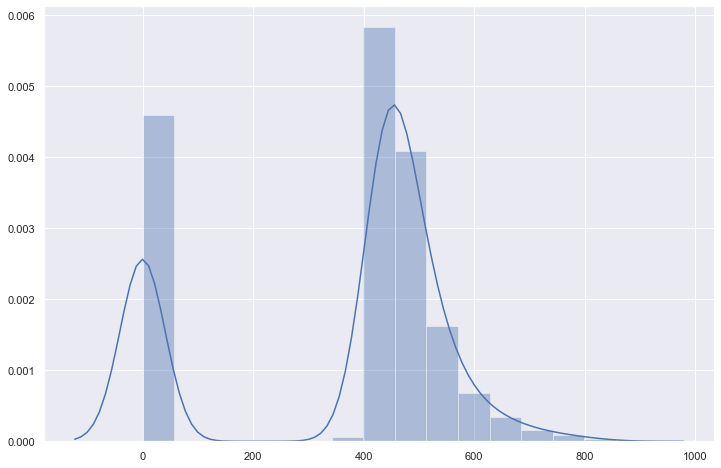

In [34]:
sns.distplot(pred)

In [35]:
# Checando se há valores a baixo de 0 ou acima de 1000.0
pred.min(), pred.max()

(0.0, 856.1592000000007)

In [38]:
answer['NU_NOTA_MT'] = pred.round(2)

In [39]:
answer

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,416.71
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,447.32
2,b38a03232f43b11c9d0788abaf060f7366053b6d,592.31
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.00
4,715494628a50142ce8cb17191cfe6d0f3cae0934,540.61
...,...,...
4571,dac0f22429c7f8e3931d0abaf5dfc8e5c772a48b,454.84
4572,a75fa8770257e7c9368d059fe53d9ef431f4bdef,486.26
4573,655fa6306720ff16e825903b5422a46608a77545,681.28
4574,1f4bc3e3d56212d500625bfe8ac78ccff4362293,460.11


In [40]:
answer.to_csv('answer.csv', index=False, header=True)